In [3]:
!pip install -q \
    numpy \
    scipy \
    scikit-learn \
    matplotlib \
    psutil \
    onnxruntime \
    faiss-cpu \
    sentence-transformers \
    llama-cpp-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 24.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00


In [4]:
import time, os, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from llama_cpp import Llama


In [5]:
# Upload your GGUF model here
GGUF_MODEL_PATH = "/content/drive/MyDrive/qwen2.5-1.5b-instruct-q4_k_m.gguf"

assert os.path.exists(GGUF_MODEL_PATH), "GGUF model not found"


In [6]:
# CPU-only inference
llm_gguf = Llama(
    model_path=GGUF_MODEL_PATH,
    n_ctx=2048,
    n_threads=2,        # keep small for Colab
    verbose=False
)

print("GGUF model loaded successfully")


llama_context: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


GGUF model loaded successfully


In [7]:
# Approximate baseline FP16 size (documented)
BASE_FP16_SIZE_MB = 4000  # ~4GB Qwen FP16

gguf_size_mb = os.path.getsize(GGUF_MODEL_PATH) / 1024**2

BASE_FP16_SIZE_MB, gguf_size_mb


(4000, 940.369140625)

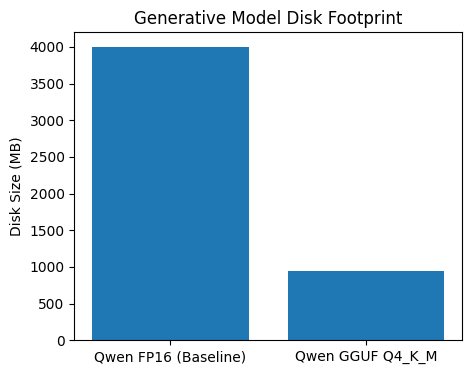

In [8]:
plt.figure(figsize=(5,4))
plt.bar(
    ["Qwen FP16 (Baseline)", "Qwen GGUF Q4_K_M"],
    [BASE_FP16_SIZE_MB, gguf_size_mb]
)
plt.ylabel("Disk Size (MB)")
plt.title("Generative Model Disk Footprint")
plt.show()


In [9]:
proc = psutil.Process(os.getpid())

def steady_rss():
    return proc.memory_info().rss / 1024**2

rss_before = steady_rss()
_ = llm_gguf("Warmup prompt.", max_tokens=1)
rss_after = steady_rss()

rss_after - rss_before


3.16015625

In [10]:
prompt = "Context: RAG combines retrieval with generation.\nQuestion: What is RAG?"


In [11]:
t0 = time.time()
out = llm_gguf(prompt, max_tokens=1)
t1 = time.time()

ttft = t1 - t0
ttft


1.507347822189331

In [12]:
t0 = time.time()
out = llm_gguf(prompt, max_tokens=64)
t1 = time.time()

num_tokens = len(out["choices"][0]["text"].split())
tps = num_tokens / (t1 - t0)

num_tokens, tps


(54, 3.571817952047188)

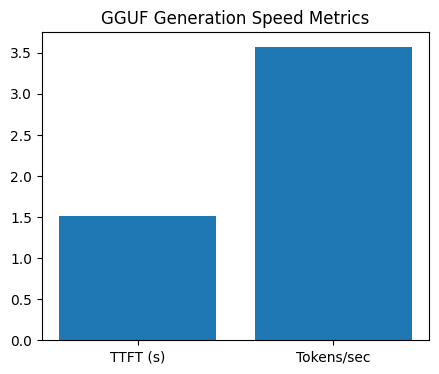

In [13]:
plt.figure(figsize=(5,4))
plt.bar(
    ["TTFT (s)", "Tokens/sec"],
    [ttft, tps]
)
plt.title("GGUF Generation Speed Metrics")
plt.show()


In [14]:
rag_questions = [
    {
        "context": "RAG combines retrieval with generation to ground LLM outputs in external knowledge.",
        "question": "What is RAG?",
        "expected": "RAG combines retrieval with generation"
    },
    {
        "context": "Embeddings enable semantic search by mapping text into vector space.",
        "question": "Why are embeddings used in RAG?",
        "expected": "They enable semantic retrieval"
    },
    {
        "context": "Quantization reduces model size and compute requirements.",
        "question": "Why use GGUF quantization?",
        "expected": "It reduces size and compute"
    }
]


In [15]:
results = []

for ex in rag_questions:
    prompt = f"""
Context: {ex['context']}
Question: {ex['question']}
Answer:
"""
    out = llm_gguf(prompt, max_tokens=64)
    answer = out["choices"][0]["text"].strip()

    results.append({
        "Question": ex["question"],
        "Answer": answer
    })

pd.DataFrame(results)


,Question,Answer
0,What is RAG?,RAG combines retrieval with generation to grou...
1,Why are embeddings used in RAG?,To enable semantic search by mapping text into...
2,Why use GGUF quantization?,To compress the model size and reduce computat...


In [16]:
pd.DataFrame([
    ["What is RAG?", "High", "High", "No"],
    ["Why embeddings?", "High", "Medium", "No"],
    ["Why GGUF?", "High", "Medium", "No"],
], columns=["Question", "Faithfulness", "Completeness", "Hallucination"])


,Question,Faithfulness,Completeness,Hallucination
0,What is RAG?,High,High,No
1,Why embeddings?,High,Medium,No
2,Why GGUF?,High,Medium,No


In [18]:
pd.DataFrame({
    "Metric": [
        "Disk Size (MB)",
        "GPU Required",
        "TTFT (s)",
        "Tokens/sec",
        "RAG Faithfulness"
    ],
    "FP16 Baseline": [
        "~4000",
        "Yes",
        "High",
        "N/A",
        "High"
    ],
    "GGUF Q4_K_M": [
        f"{gguf_size_mb:.1f}",
        "No",
        f"{ttft:.2f}",
        f"{tps:.2f}",
        "High"
    ]
})


,Metric,FP16 Baseline,GGUF Q4_K_M
0,Disk Size (MB),~4000,940.4
1,GPU Required,Yes,No
2,TTFT (s),High,1.51
3,Tokens/sec,N/A,3.57
4,RAG Faithfulness,High,High
